Study how lexical coherence relations are preserved by aggregation functions over time.
This is relevant because the brain encoding pipeline aggregates these over time.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:
import sys
sys.path.append("../")

In [148]:
import itertools
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import torch
from tqdm.auto import tqdm

from src.analysis import coherence
from src.analysis.state_space import StateSpaceAnalysisSpec, \
    prepare_state_trajectory, aggregate_state_trajectory
from src.datasets.speech_equivalence import SpeechEquivalenceDataset

In [9]:
model_dir = "outputs/models/timit/w2v2_6/rnn_8-aniso2/word_broad_10frames"
output_dir = "."
dataset_path = "outputs/preprocessed_data/timit"
equivalence_path = "outputs/equivalence_datasets/timit/w2v2_6/word_broad_10frames/equivalence.pkl"
hidden_states_path = "outputs/hidden_states/timit/w2v2_6/hidden_states.pkl"
state_space_specs_path = "outputs/state_space_specs/timit/w2v2_6/state_space_specs.pkl"
embeddings_path = "outputs/model_embeddings/timit/w2v2_6/rnn_8-weightdecay0.01/word_broad_10frames/embeddings.npy"

metric = "cosine"

# Retain words with N or more instances
retain_n = 10

In [10]:
with open(embeddings_path, "rb") as f:
    model_representations: np.ndarray = np.load(f)
with open(equivalence_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = torch.load(f)
with open(state_space_specs_path, "rb") as f:
    state_space_spec: StateSpaceAnalysisSpec = torch.load(f)["word"]
assert state_space_spec.is_compatible_with(model_representations)

In [11]:
drop_idxs = [idx for idx, target_frames in enumerate(state_space_spec.target_frame_spans)
               if len(target_frames) < retain_n]
state_space_spec = state_space_spec.drop_labels(drop_idxs)

In [12]:
agg_fns = [
    "mean", "max", "last_frame",
    ("mean_last_k", 2), ("mean_last_k", 5),
]

In [13]:
trajectory = prepare_state_trajectory(model_representations, state_space_spec, pad=np.nan)
lengths = [np.isnan(traj_i[:, :, 0]).argmax(axis=1) for traj_i in trajectory]

In [25]:
trajectory_aggs = {agg_fn: aggregate_state_trajectory(trajectory, agg_fn, keepdims=True)
                   for agg_fn in agg_fns}
dummy_lengths = [np.ones(len(traj_i), dtype=int) for traj_i in trajectory]

In [16]:
len(trajectory), np.concatenate(lengths).mean()

(590, 12.599139818177136)

## Estimate within-word distance

In [76]:
within_distance_dfs = {}

for agg_fn, traj_agg in tqdm(trajectory_aggs.items(), unit="aggfn"):
    within_distance, within_distance_offset = \
        coherence.estimate_within_distance(traj_agg, dummy_lengths, state_space_spec, metric=metric)

    within_distance_dfs[agg_fn] = pd.DataFrame(
        within_distance, columns=["distance"], index=pd.Index(state_space_spec.labels, name="word"))

  0%|          | 0/5 [00:00<?, ?aggfn/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

## Estimate between-word distance

In [77]:
between_distance_dfs = {}

for agg_fn, traj_agg in tqdm(trajectory_aggs.items(), unit="aggfn"):
    between_distance, between_distance_offset = \
        coherence.estimate_between_distance(traj_agg, dummy_lengths, state_space_spec, metric=metric)

    between_distance_dfs[agg_fn] = pd.DataFrame(
        between_distance.squeeze(1).mean(axis=-1),
        columns=["distance"], index=pd.Index(state_space_spec.labels, name="word"))

  0%|          | 0/5 [00:00<?, ?aggfn/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

## Together

In [78]:
merged_df = pd.concat({
    "within": pd.concat(within_distance_dfs, names=["agg_fn"]),
    "between": pd.concat(between_distance_dfs, names=["agg_fn"]),
}, names=["type"])
merged_df

distance
type    agg_fn           word              
within  mean             she       0.008267
                         had       0.056423
                         your      0.093661
                         dark      0.007562
                         suit      0.007782
...                                     ...
between (mean_last_k, 5) overalls  0.933137
                         greg      0.994102
                         potatoes  1.184098
                         i'd       1.079009
                         tooth     0.955961

[5900 rows x 1 columns]

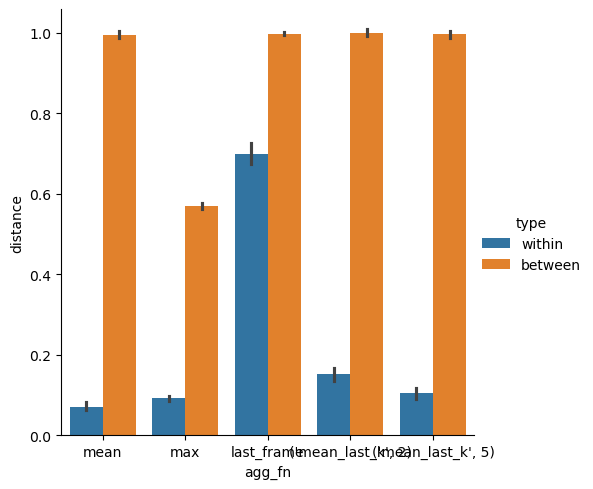

In [79]:
ax = sns.catplot(data=merged_df.reset_index(),
                 x="agg_fn", y="distance", hue="type", kind="bar")
# ax.set_title("Representational distance within- and between-word")
# ax.set_xlabel("Frames since word onset")
# ax.set_ylabel(f"{metric.capitalize()} distance")

## Estimate distance by grouping features

### Onset

In [86]:
onsets = [word[0] for word in state_space_spec.labels]

onset_distance_dfs = {}
for agg_fn, traj_agg in tqdm(trajectory_aggs.items(), unit="aggfn"):
    onset_distance_dfs[agg_fn], _ = coherence.estimate_category_within_between_distance(
        traj_agg, dummy_lengths, onsets, metric=metric, labels=state_space_spec.labels
    )

  0%|          | 0/5 [00:00<?, ?aggfn/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

In [88]:
onset_distance_df = pd.concat(onset_distance_dfs, names=["agg_fn"])

In [89]:
onset_distance_df.to_csv(Path(output_dir) / "distances-grouped_onset.csv")

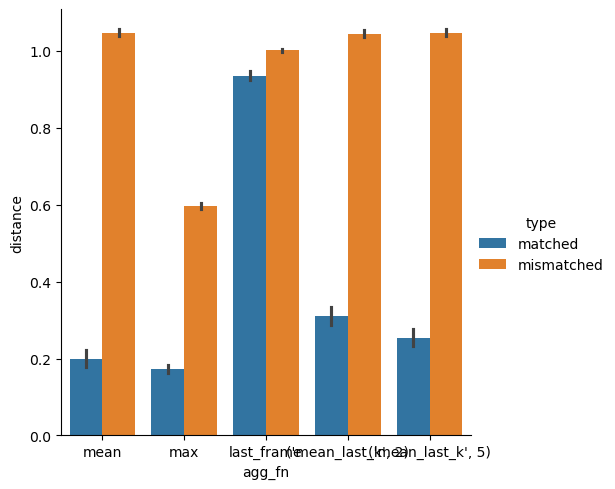

In [90]:
ax = sns.catplot(data=onset_distance_df, x="agg_fn", y="distance", hue="type", kind="bar")
# ax.set_title("Representational distance by onset match/mismatch")
# ax.set_xlabel("Frames since word onset")
# ax.set_ylabel(f"{metric.capitalize()} distance")

### Offset

In [91]:
offsets = [word[-1] for word in state_space_spec.labels]

offset_distance_dfs = {}
for agg_fn, traj_agg in tqdm(trajectory_aggs.items(), unit="aggfn"):
    offset_distance_dfs[agg_fn], _ = coherence.estimate_category_within_between_distance(
        traj_agg, dummy_lengths, offsets, metric=metric, labels=state_space_spec.labels
    )

  0%|          | 0/5 [00:00<?, ?aggfn/s]

  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:243: RuntimeWarning: Mean of empty slice
  merged_df = pd.concat([matched_df.assign(type="matched"), mismatched_df.assign(type="mismatched")])
/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:249: RuntimeWarning: Mean of empty slice
  merged_offset_df = pd.concat([matched_offset_df.assign(type="matched"), mismatched_offset_df.assign(type="mismatched")])


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:243: RuntimeWarning: Mean of empty slice
  merged_df = pd.concat([matched_df.assign(type="matched"), mismatched_df.assign(type="mismatched")])
/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:249: RuntimeWarning: Mean of empty slice
  merged_offset_df = pd.concat([matched_offset_df.assign(type="matched"), mismatched_offset_df.assign(type="mismatched")])


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:243: RuntimeWarning: Mean of empty slice
  merged_df = pd.concat([matched_df.assign(type="matched"), mismatched_df.assign(type="mismatched")])
/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:249: RuntimeWarning: Mean of empty slice
  merged_offset_df = pd.concat([matched_offset_df.assign(type="matched"), mismatched_offset_df.assign(type="mismatched")])


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:243: RuntimeWarning: Mean of empty slice
  merged_df = pd.concat([matched_df.assign(type="matched"), mismatched_df.assign(type="mismatched")])
/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:249: RuntimeWarning: Mean of empty slice
  merged_offset_df = pd.concat([matched_offset_df.assign(type="matched"), mismatched_offset_df.assign(type="mismatched")])


  0%|          | 0/590 [00:00<?, ?it/s]

  0%|          | 0/590 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:243: RuntimeWarning: Mean of empty slice
  merged_df = pd.concat([matched_df.assign(type="matched"), mismatched_df.assign(type="mismatched")])
/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:249: RuntimeWarning: Mean of empty slice
  merged_offset_df = pd.concat([matched_offset_df.assign(type="matched"), mismatched_offset_df.assign(type="mismatched")])


In [92]:
offset_distance_df = pd.concat(offset_distance_dfs, names=["agg_fn"])

In [93]:
offset_distance_df.to_csv(Path(output_dir) / "distances-grouped_offset.csv")

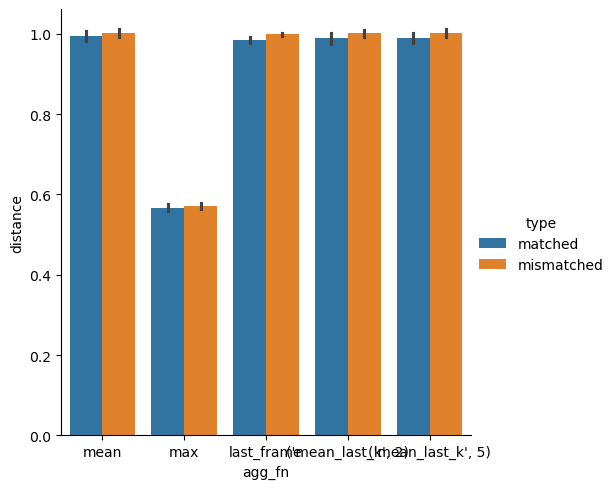

In [95]:
sns.catplot(data=offset_distance_df.reset_index(), x="agg_fn", y="distance", hue="type", kind="bar")

In [96]:
offset_distance_df

label frame  distance        type
agg_fn                                                    
mean             0         she     0  1.076785     matched
                 1         had     0  0.887835     matched
                 2        your     0  0.754323     matched
                 3        dark     0  0.951784     matched
                 4        suit     0  0.943620     matched
...                        ...   ...       ...         ...
(mean_last_k, 5) 585  overalls     0  1.216153  mismatched
                 586      greg     0  1.013845  mismatched
                 587  potatoes     0  1.094362  mismatched
                 588       i'd     0  1.000789  mismatched
                 589     tooth     0  0.898972  mismatched

[5900 rows x 4 columns]

## Model-free exploration

In [115]:
knn_references = np.concatenate(trajectory_aggs["mean"]).squeeze(1)
knn_reference_ids = np.concatenate([np.stack([np.ones(len(traj)) * i, np.arange(len(traj))]).T
                                   for i, traj in enumerate(trajectory_aggs["mean"])], axis=0).astype(int)

assert len(knn_references) == len(knn_reference_ids)

In [121]:
knn_instances = np.random.choice(len(knn_references), 10, replace=False)

In [122]:
from scipy.spatial.distance import cdist, pdist, squareform

In [125]:
for knn_instance in knn_instances:
    ref_embedding = knn_references[knn_instance]
    knn_instance_results = cdist(knn_references, ref_embedding[None, :], metric=metric).ravel()

    print(state_space_spec.labels[knn_reference_ids[knn_instance][0]], knn_reference_ids[knn_instance][1])
    print("Nearest neighbors:")
    for class_idx, instance_idx in knn_reference_ids[knn_instance_results.argsort()[1:10]]:
        print("\t", state_space_spec.labels[class_idx], instance_idx)
    print("Furthest neighbors:")
    for class_idx, instance_idx in knn_reference_ids[-knn_instance_results.argsort()[1:10]]:
        print("\t", state_space_spec.labels[class_idx], instance_idx)
    print()

here 15
Nearest neighbors:
	 her 102
	 here 16
	 age 1
	 need 29
	 age 10
	 age 4
	 his 164
	 yellow 9
	 ocean 5
Furthest neighbors:
	 is 331
	 in 945
	 suit 334
	 don't 361
	 suit 325
	 suit 331
	 that 199
	 had 612
	 your 477

enjoy 14
Nearest neighbors:
	 he 267
	 you 49
	 in 543
	 each 13
	 in 958
	 in 799
	 each 50
	 huge 19
	 academic 3
Furthest neighbors:
	 now 42
	 carry 424
	 open 9
	 don't 570
	 here 3
	 three 20
	 don't 533
	 rag 456
	 rag 414

only 46
Nearest neighbors:
	 our 22
	 only 43
	 early 0
	 only 5
	 high 32
	 are 228
	 hallway 10
	 our 52
	 orange 14
Furthest neighbors:
	 to 406
	 water 112
	 don't 643
	 water 150
	 water 367
	 and 78
	 she 545
	 to 376
	 all 123

people 26
Nearest neighbors:
	 be 49
	 put 27
	 birth 2
	 put 13
	 brother 3
	 sat 9
	 please 39
	 be 118
	 big 66
Furthest neighbors:
	 an 418
	 suit 416
	 she 300
	 suit 430
	 dark 164
	 she 98
	 water 172
	 an 349
	 an 627

don't 385
Nearest neighbors:
	 don't 399
	 don't 371
	 don't 580
	 day 18
	 do

### RSA, collapsed over instances

In [137]:
rsa_distances = {}

for agg_fn, traj_agg in tqdm(trajectory_aggs.items(), unit="aggfn"):
    rsa_references = np.stack([np.mean(traj_agg_i.squeeze(1), axis=0) for traj_agg_i in traj_agg])
    rsa_distances[agg_fn] = pd.DataFrame(
        squareform(pdist(rsa_references, metric=metric)),
        index=state_space_spec.labels,
        columns=state_space_spec.labels
    )

  0%|          | 0/5 [00:00<?, ?aggfn/s]

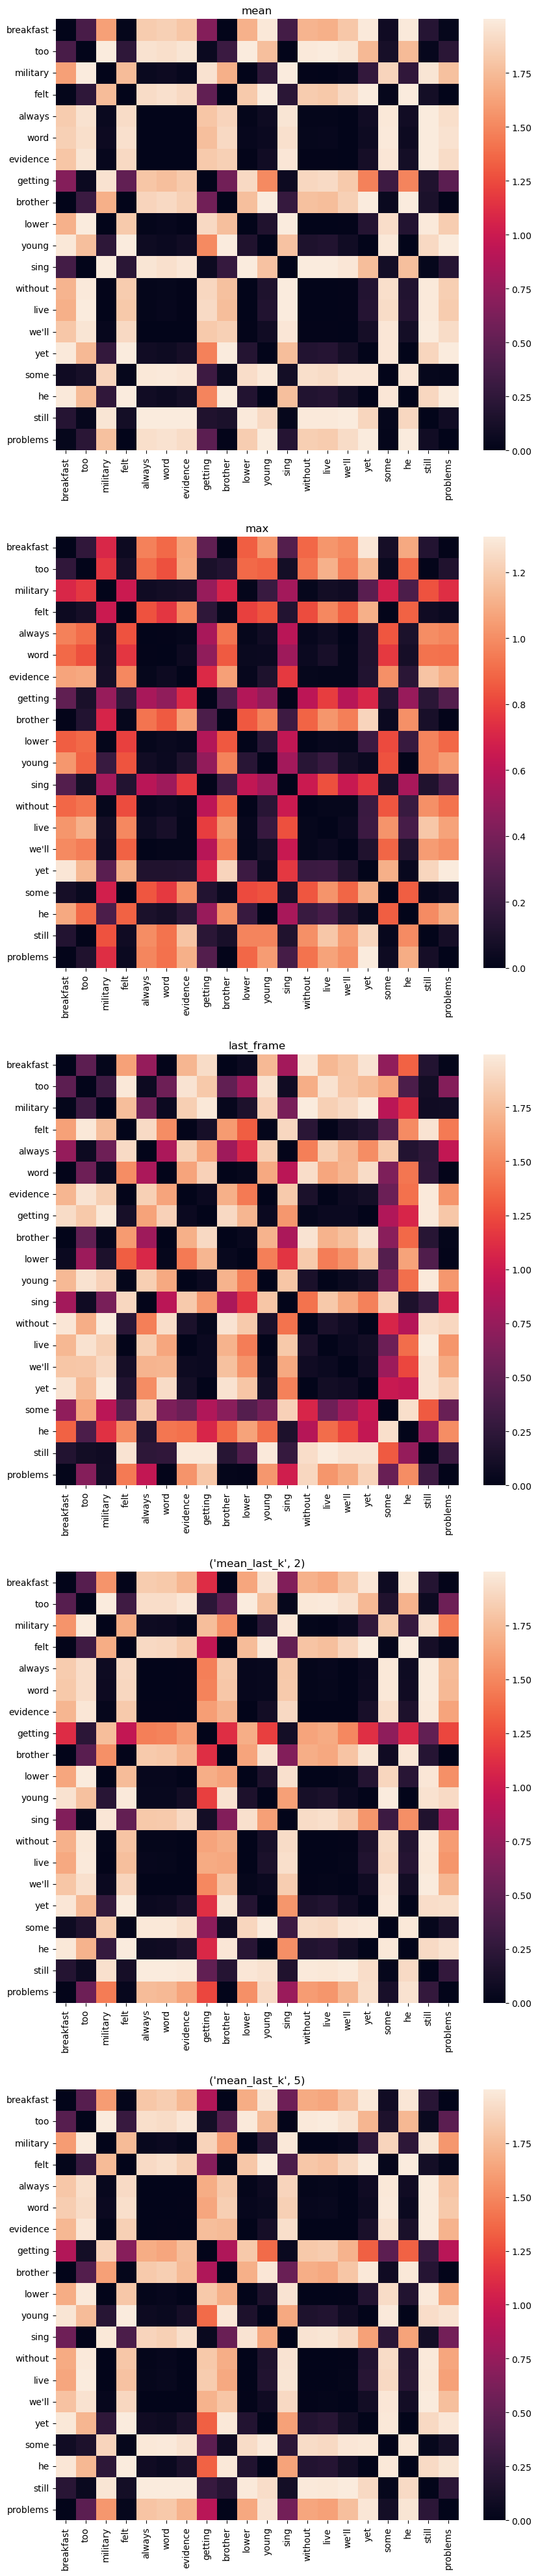

In [142]:
rsa_viz_sample = np.random.choice(state_space_spec.labels, size=20, replace=False)

f, axs = plt.subplots(len(agg_fns), 1, figsize=(10, 10 * len(agg_fns)))
for ax, (agg_fn, rsa_distances_i) in zip(axs.ravel(), rsa_distances.items()):
    rsa_viz = rsa_distances_i.loc[rsa_viz_sample, rsa_viz_sample]
    sns.heatmap(rsa_viz, ax=ax)
    ax.set_title(agg_fn)

In [159]:
rsa_sims = {}
for agg1, agg2 in itertools.product(agg_fns, repeat=2):
    rsa_triu1 = rsa_distances[agg1].values[np.triu_indices(len(rsa_distances[agg1]), k=1)]
    rsa_triu2 = rsa_distances[agg2].values[np.triu_indices(len(rsa_distances[agg2]), k=1)]
    rsa_sims[agg1, agg2] = scipy.stats.spearmanr(rsa_triu1, rsa_triu2)[0]

In [160]:
rsa_sims = pd.Series(rsa_sims)
rsa_sims.index.set_names(["agg1", "agg2"], inplace=True)
rsa_sims

agg1              agg2            
mean              mean                1.000000
                  max                 0.900451
                  last_frame          0.395699
                  (mean_last_k, 2)    0.952015
                  (mean_last_k, 5)    0.974917
max               mean                0.900451
                  max                 1.000000
                  last_frame          0.529986
                  (mean_last_k, 2)    0.904711
                  (mean_last_k, 5)    0.902152
last_frame        mean                0.395699
                  max                 0.529986
                  last_frame          1.000000
                  (mean_last_k, 2)    0.455509
                  (mean_last_k, 5)    0.413754
(mean_last_k, 2)  mean                0.952015
                  max                 0.904711
                  last_frame          0.455509
                  (mean_last_k, 2)    1.000000
                  (mean_last_k, 5)    0.985468
(mean_last_k, 5)  mean   

Text(0.5, 1.0, 'Similarity in word-level RSA')

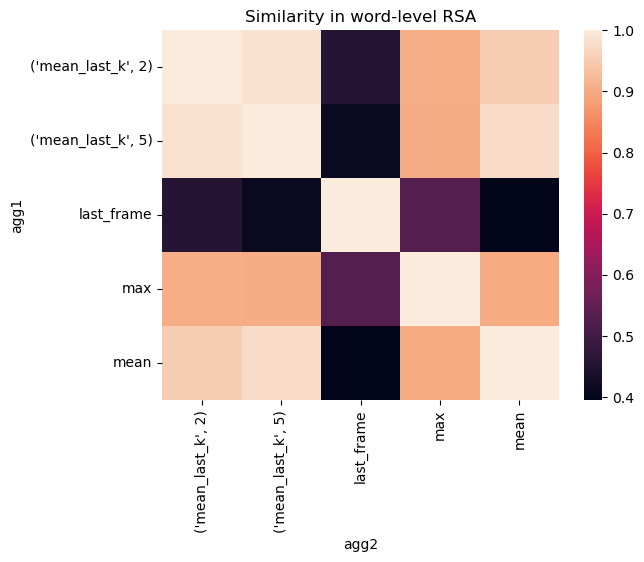

In [163]:
ax = sns.heatmap(rsa_sims.unstack())
ax.set_title("Similarity in word-level RSA")

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


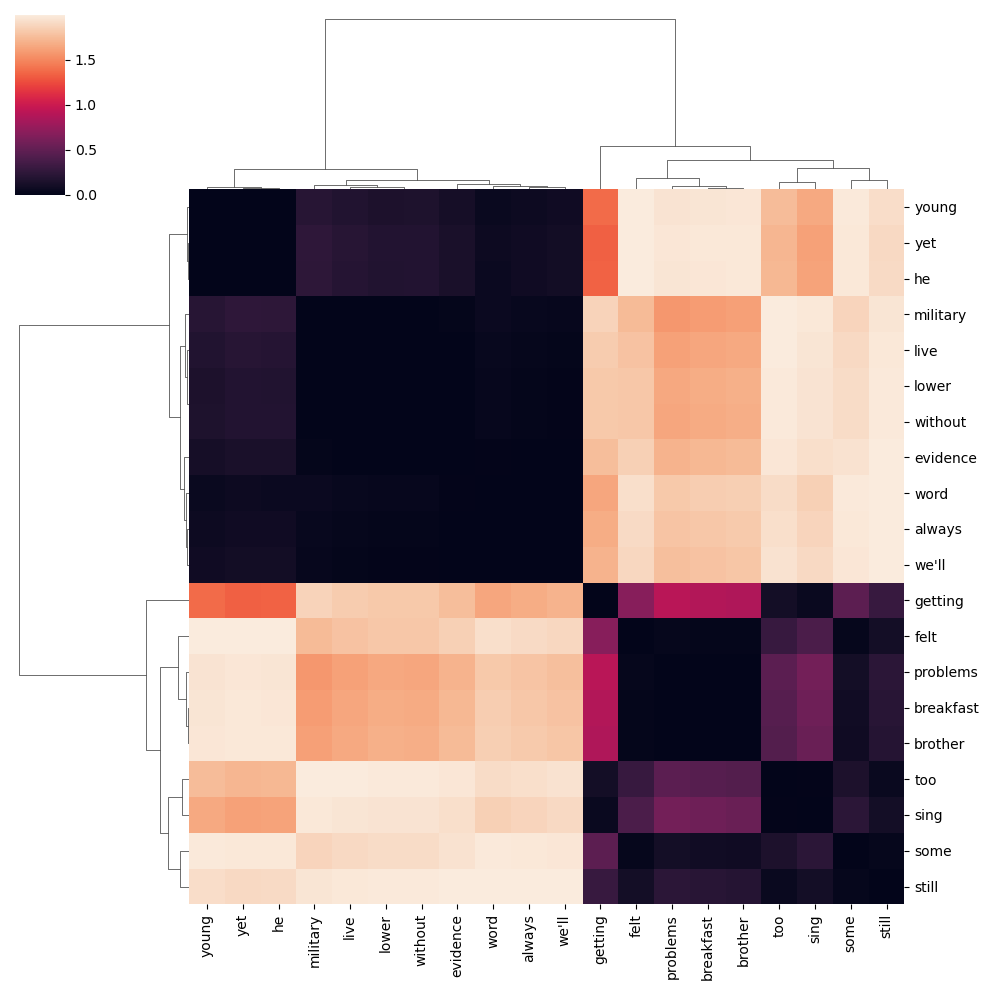

In [143]:
sns.clustermap(rsa_viz)